# CS 444 Final Project

## 1.Mask R-CNN

In [1]:
import torch
import torchvision
import numpy as np
import random
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [28]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


net = maskrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 2
#Change number of classes to 2 (pedestrian and background)
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# now get the number of input features for the mask classifier
in_features_mask = net.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
net.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask,
    hidden_layer,
    num_classes
)

net.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

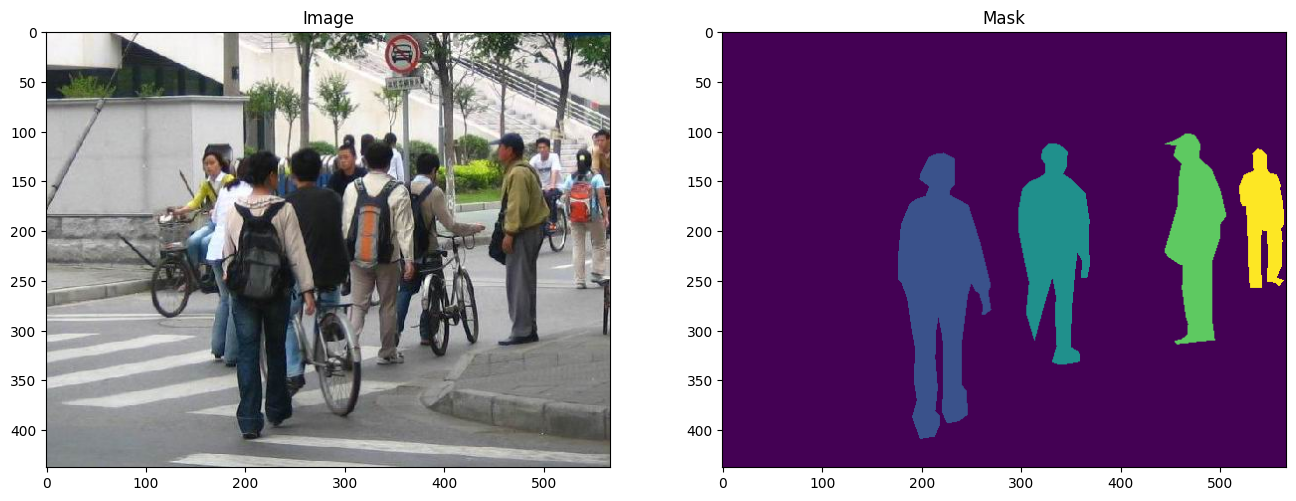

In [5]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PNGImages/FudanPed00046.png")
mask = read_image("data/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [6]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))


In [7]:
dataset = PennFudanDataset('data', get_transform(train=True))
dataset_test = PennFudanDataset('data', get_transform(train=False))
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)


In [8]:
dataiter = iter(data_loader)
img,target = next(dataiter)


In [9]:
def train(net, optimizer, num_epochs, decay_epochs, init_lr):
    net.train()
    lr = init_lr
    for epoch in range(num_epochs):
        if epoch > 0 and epoch % decay_epochs == 0:
            lr = lr * 0.1
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = net(images, targets)
            loss = sum(l for l in loss_dict.values())
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}   Loss: {loss}")
            

In [30]:
params = [p for p in net.parameters() if p.requires_grad]
lr = 0.001
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9,weight_decay=0.0005)

train(net, optimizer, 30, 15, lr)

Epoch: 0   Loss: 0.45032408833503723
Epoch: 1   Loss: 0.1900833547115326
Epoch: 2   Loss: 0.2565051019191742
Epoch: 3   Loss: 0.25928613543510437
Epoch: 4   Loss: 0.23483525216579437
Epoch: 5   Loss: 0.28228485584259033
Epoch: 6   Loss: 0.16245967149734497
Epoch: 7   Loss: 0.1265823096036911
Epoch: 8   Loss: 0.18692581355571747
Epoch: 9   Loss: 0.22266250848770142
Epoch: 10   Loss: 0.17774014174938202
Epoch: 11   Loss: 0.16113722324371338
Epoch: 12   Loss: 0.16683423519134521
Epoch: 13   Loss: 0.13477887213230133
Epoch: 14   Loss: 0.1575629711151123
Epoch: 15   Loss: 0.1168878823518753
Epoch: 16   Loss: 0.14542396366596222
Epoch: 17   Loss: 0.10811348259449005
Epoch: 18   Loss: 0.12972086668014526
Epoch: 19   Loss: 0.12313675135374069
Epoch: 20   Loss: 0.22339101135730743
Epoch: 21   Loss: 0.18332423269748688
Epoch: 22   Loss: 0.11724260449409485
Epoch: 23   Loss: 0.09330036491155624
Epoch: 24   Loss: 0.12071573734283447
Epoch: 25   Loss: 0.16230502724647522
Epoch: 26   Loss: 0.1571934

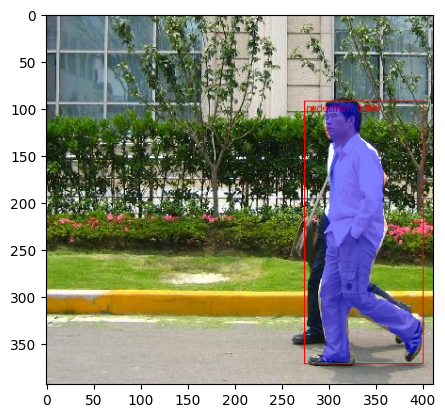

In [31]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
images, targets = next(iter(data_loader_test))
x = images[0].to(device)

net.eval()
predictions = net([x,])
pred = predictions[0]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
image = draw_bounding_boxes(x,pred["boxes"],pred_labels, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")
plt.imshow(image.permute(1,2,0))

In [12]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

2.6.0+cu118
0.21.0+cpu
11.8
